In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Fourier and Bspline basis

In [22]:
class fourier_basis():
    def __init__(self, interval = [0, 1], n = 5):
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.functions = []
        for i in range(0, self.n+1):
            if i%2 == 1:
                self.functions.append(lambda x, i=i: np.sin(2 * np.pi * ((i//2) + 1) * x / (self.end - self.start)))
            else: 
                self.functions.append(lambda x, i=i: np.cos(2 * np.pi * (i//2) * x / (self.end - self.start)))

    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        plt.xlim([self.start, self.end])
        plt.show()

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

In [83]:
class bspline_basis():
    def __init__(self, interval = [0, 1], n = 5, order = 4, breaks = None):
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.order = order
        self.functions = []
        if breaks is None:
            n_breaks = self.n - self.order + 2
            self.breaks = np.linspace(self.start, self.end, n_breaks)
        else:
            self.breaks = np.array(breaks)
        self.knots = self.compute_knots(self.order)
        self.functions = [self.basis_function(i, self.order) for i in range(len(self.knots) - self.order)]

    def compute_knots(self, order):
        """Create the sequence of knots needed for the bsplines of order order"""
        t_start = np.repeat(self.start, order)
        t_end = np.repeat(self.end, order)
        internal_knots = self.breaks[1:-1]
        return np.concatenate([t_start, internal_knots, t_end])

    def basis_function(self, i, k):
        """Cox-de Boor recursion implementation"""
        if k == 1:
            def b(x):
                # Handling the discontinuity for the last spline
                if i == len(self.knots) - self.order - 1:
                    return np.where((self.knots[i] <= x) & (x <= self.knots[i + 1]), 1.0, 0.0)
                else:
                    return np.where((self.knots[i] <= x) & (x < self.knots[i + 1]), 1.0, 0.0)
            return b
        else:
            def b(x):
                left = np.zeros_like(x, dtype=float)
                right = np.zeros_like(x, dtype=float)
                if self.knots[i + k - 1] != self.knots[i]:
                    left = ((x - self.knots[i]) / (self.knots[i + k - 1] - self.knots[i])) * self.basis_function(i, k - 1)(x)
                if self.knots[i + k] != self.knots[i + 1]:
                    right = ((self.knots[i + k] - x) / (self.knots[i + k] - self.knots[i + 1])) * self.basis_function(i + 1, k - 1)(x)
                return left + right
            return b

    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        for br in self.knots[self.order:-self.order]:
            plt.axvline(br, c='r', linestyle = 'dashed', alpha=0.5)
        plt.xlim([self.start, self.end])
        plt.show()

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

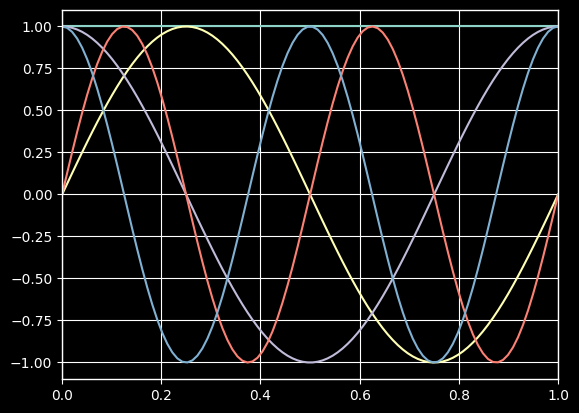

In [112]:
fourier_basis(n=4).plot()

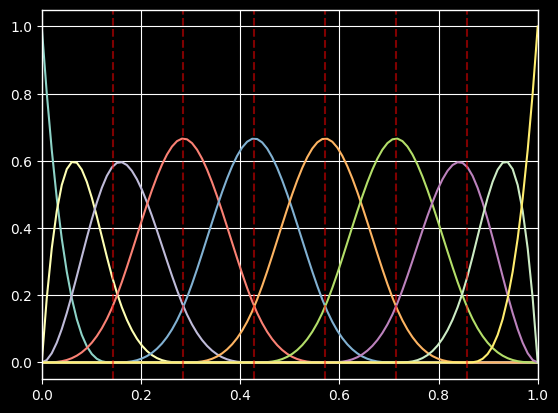

In [113]:
# Plotting 10 cubic splines
bspline_basis(n=10, order = 4).plot()

## Smoothing functions on the Canadian weather data

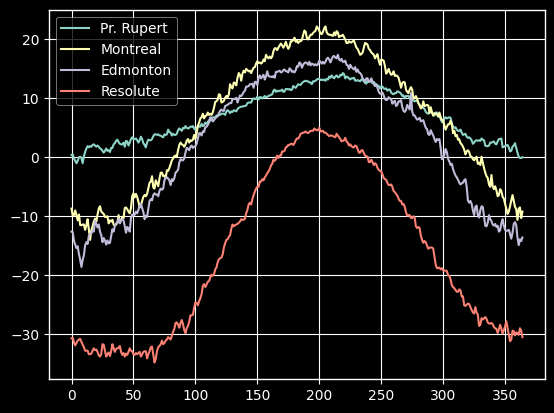

In [114]:
data = pd.read_table('can_weather.tsv')
stations = data.columns
temp = data.values
plt.plot(np.arange(len(temp)),temp)
plt.legend(stations)
plt.show()

In [68]:
def ols_fit(input, targets, base_type = 'fourier', n = 5, lbd = 0.001):
    if base_type == 'fourier':
        X = fourier_basis(n=n, interval=input).evaluate(input).T
    elif base_type == 'bspline':
        X = bspline_basis(n=n, interval=input).evaluate(input).T
    y = targets
    b = np.linalg.solve(X.T @ X + lbd * np.eye(X.shape[1]), X.T @ y)
    return X @ b

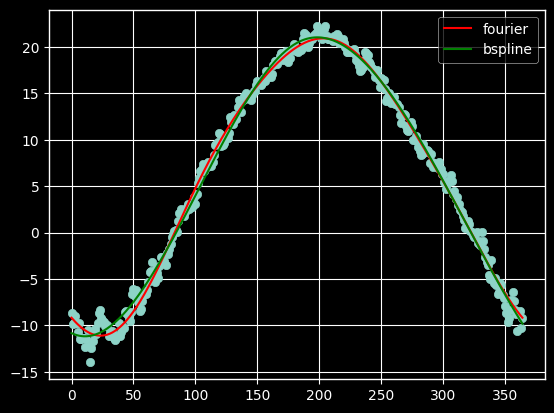

In [117]:
# Comparing bsplines and fourier basis smoothing
montreal = temp[:,1]
day = np.arange(len(montreal))
plt.scatter(day, montreal)
for j in [['fourier','r'], ['bspline','g']]:
    plt.plot(day, ols_fit(day, montreal, base_type=j[0]), c=j[1], label=j[0])
plt.legend()
plt.show()

## Confidence interval

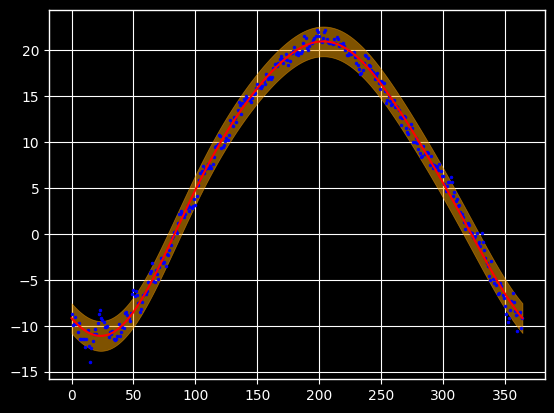

In [118]:
nbasis = 5
fourier_pred = ols_fit(day, montreal, base_type='fourier', n = nbasis)
# Estimating the 95% confidence interval
var = np.sum((fourier_pred - montreal) ** 2) / (365 - nbasis)
plt.fill_between(day, fourier_pred - 2 * np.sqrt(var), fourier_pred + 2 * np.sqrt(var), alpha = 0.5, color='orange')
plt.plot(day, fourier_pred, c='r')
plt.scatter(day, montreal, s=4, c='b')
plt.show()